In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import math
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import scale, OneHotEncoder, StandardScaler

In [3]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure()
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='test loss')
    plt.xlabel('iterations')
    plt.ylabel('losses')
    plt.legend()

    plt.figure()
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='test accuracy')
    plt.xlabel('iterations')
    plt.ylabel('accuracy')
    plt.legend()

In [4]:
# Load and preprocess audio files (e.g., extract MFCC)
def extract_features(file_path, features=['mel', 'mfcc', 'chroma'], sr=22050, n_mfcc=40):
    try:
        x, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        feature_list = []

        if 'mfcc' in features:
            mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=n_mfcc)
            mfccs_scaled = np.mean(mfccs.T, axis=0)
            feature_list.append(mfccs_scaled)

        if 'mel' in features:
            mel = librosa.feature.melspectrogram(y=x, sr=sr)
            mel_scaled = np.mean(mel.T, axis=0)
            feature_list.append(mel_scaled)

        if 'chroma' in features:
            chroma = librosa.feature.chroma_stft(y=x, sr=sr)
            chroma_scaled = np.mean(chroma.T, axis=0)

        return np.concatenate(feature_list, axis=0)
    
    except Exception as e:
        print(f"Error extracting reafures from {file_path}: {e}")
        

In [5]:
import os
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

def load_dataset(type, features=['mel', 'mfcc', 'chroma'], train_size=0.8):
    dir = r'C:\Users\rupes\OneDrive\Documents\Data Science\Speech Emotion Recognition\audio_dataset'
    
    X = []
    Y = []

    for folder in os.listdir(dir):
        folder_path = os.path.join(dir, folder)

        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)

                if os.path.isfile(file_path):
                        features_extracted = extract_features(file_path)

                        if features_extracted is not None:
                            X.append(features_extracted)
                            
                            audio_path = file_path.split('\\')[-1] 
                            parts = audio_path.split('.')[0].split('-')
                            
                            if type == 'emotion':
                                Y.append(int(parts[2]))
                            elif type == 'gender':
                                actor_id = int(parts[6]) 
                                gender = 0 if actor_id % 2 == 0 else 1
                                Y.append(gender)


    if len(Y) == 0:
        print("No valid audio files processed for type:", type)
        return None, None, None, None

    X = np.array(X)
    Y = np.array(Y).reshape(-1, 1)
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    encoder = OneHotEncoder()
    Y = encoder.fit_transform(Y).toarray()

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    return x_train, y_train, x_test, y_test


In [6]:
# Loading the data
xe_train, ye_train, xe_test, ye_test = load_dataset(type='emotion')
xg_train, yg_train, xg_test, yg_test = load_dataset(type='gender')

In [25]:
print('xe_train shape:', xe_train.shape)  # Should be (num_samples, timesteps, features)
print('ye_train shape:', ye_train.shape)  # Should be (num_samples,) for classification
print('Unique labels:', np.unique(ye_train))  

xe_train shape: (1152, 168)
ye_train shape: (1152, 8)
Unique labels: [0. 1.]


# Emotion Analysis Model

In [7]:

def build_emotion_model(input_shape, x_train, y_train, x_test, y_test):
    # Build the model
    model = models.Sequential()
    model.add(layers.Conv1D(128, kernel_size=(10), activation='relu', input_shape=input_shape))
    model.add(layers.Conv1D(256, kernel_size=(10), activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(256, kernel_size=(10), activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(128, kernel_size=(5), padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer='l2'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(8, activation='softmax'))  # Use softmax for multi-class classification
    

    # Use Adam optimizer with learning rate decay
    initial_learning_rate = 0.0001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
    )

    # Compile the model
    optimizer = optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    # Train the model and return the history
    history = model.fit(x_train, y_train, batch_size=128, epochs=500, validation_data=(x_test, y_test))
    
    # Plot the history
    plot_history(history)

    # Model summary and result on test_data
    print(model.summary())
    result = model.evaluate(x_test, y_test)
    print(result)
    
    return model

Epoch 1/500
9/9 [==============================] - 4s 378ms/step - loss: 4.0873 - accuracy: 0.1380 - val_loss: 4.0233 - val_accuracy: 0.1458
Epoch 2/500
9/9 [==============================] - 3s 352ms/step - loss: 4.0128 - accuracy: 0.1354 - val_loss: 3.9318 - val_accuracy: 0.1458
Epoch 3/500
9/9 [==============================] - 3s 300ms/step - loss: 3.9349 - accuracy: 0.1441 - val_loss: 3.8489 - val_accuracy: 0.1354
Epoch 4/500
9/9 [==============================] - 3s 320ms/step - loss: 3.8678 - accuracy: 0.1641 - val_loss: 3.7851 - val_accuracy: 0.1562
Epoch 5/500
9/9 [==============================] - 3s 323ms/step - loss: 3.8041 - accuracy: 0.1641 - val_loss: 3.7211 - val_accuracy: 0.1562
Epoch 6/500
9/9 [==============================] - 3s 334ms/step - loss: 3.7544 - accuracy: 0.1727 - val_loss: 3.6647 - val_accuracy: 0.1944
Epoch 7/500
9/9 [==============================] - 3s 329ms/step - loss: 3.6973 - accuracy: 0.2040 - val_loss: 3.6063 - val_accuracy: 0.2153
Epoch 8/500
9

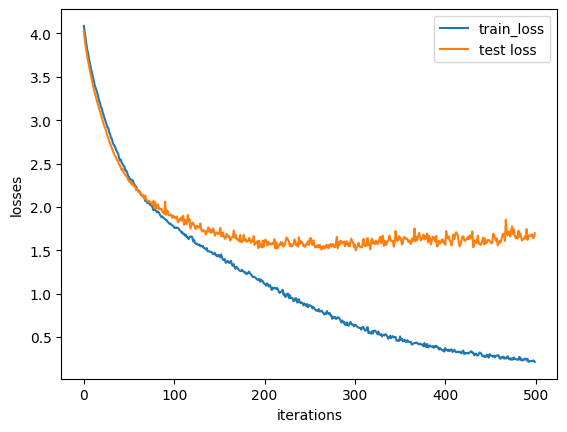

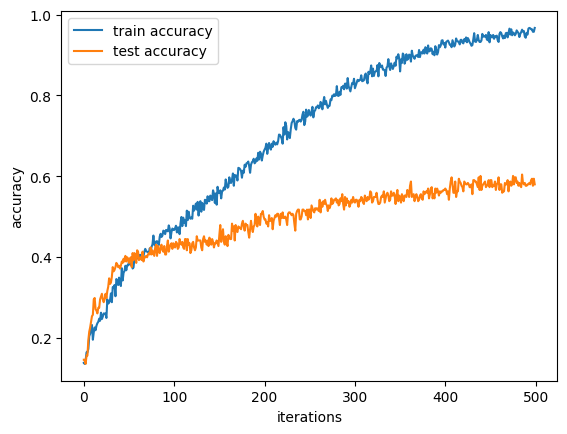

In [8]:
input_shape = (xe_train.shape[1], 1)  # Adjust based on your X_train shape
emotion_model = build_emotion_model(input_shape, xe_train, ye_train, xe_test, ye_test)

In [9]:
print(emotion_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 159, 128)          1408      
                                                                 
 conv1d_1 (Conv1D)           (None, 150, 256)          327936    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 256)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 18, 256)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 9, 256)            655616    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 256)           0         
 1D)                                                    

# Gender Classification Model

In [10]:
# load the dataset 
xg_train, yg_train, xg_test, yg_test = load_dataset(type='gender')

In [11]:
def build_gender_classification_model(input_shape, x_train, y_train, x_test, y_test):
    # Build the model
    model = models.Sequential()
    model.add(layers.Conv1D(128, kernel_size=(10), activation='relu', input_shape=input_shape))
    model.add(layers.Conv1D(256, kernel_size=(10), activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=(2)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(256, kernel_size=(10), activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=(2)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(128, kernel_size=(5), padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.Flatten())
    
    model.add(layers.Dense(512, activation='relu', kernel_regularizer='l2'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(2, activation='softmax'))  # Use softmax for multi-class classification
    
    # Use Adam optimizer with learning rate decay
    initial_learning_rate = 0.0001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
    )

    # Compile the model
    optimizer = optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    # Train the model and return the history
    history = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))
    
    # Plot the history
    plot_history(history)

    # Model summary and result on test_data
    print(model.summary())
    result = model.evaluate(x_test, y_test)
    print(result)
    
    return model

Epoch 1/100
9/9 [==============================] - 8s 725ms/step - loss: 9.5423 - accuracy: 0.6580 - val_loss: 9.1738 - val_accuracy: 0.8438
Epoch 2/100
9/9 [==============================] - 6s 662ms/step - loss: 8.8809 - accuracy: 0.7925 - val_loss: 8.4915 - val_accuracy: 0.8854
Epoch 3/100
9/9 [==============================] - 6s 646ms/step - loss: 8.2234 - accuracy: 0.8247 - val_loss: 7.8223 - val_accuracy: 0.8924
Epoch 4/100
9/9 [==============================] - 6s 662ms/step - loss: 7.6372 - accuracy: 0.8438 - val_loss: 7.2894 - val_accuracy: 0.9028
Epoch 5/100
9/9 [==============================] - 6s 641ms/step - loss: 7.1493 - accuracy: 0.8620 - val_loss: 6.8323 - val_accuracy: 0.9167
Epoch 6/100
9/9 [==============================] - 6s 650ms/step - loss: 6.7036 - accuracy: 0.8733 - val_loss: 6.4032 - val_accuracy: 0.9340
Epoch 7/100
9/9 [==============================] - 6s 651ms/step - loss: 6.2923 - accuracy: 0.8802 - val_loss: 6.0198 - val_accuracy: 0.9236
Epoch 8/100
9

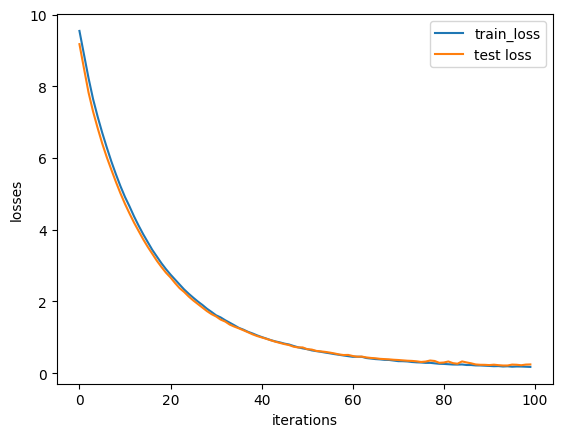

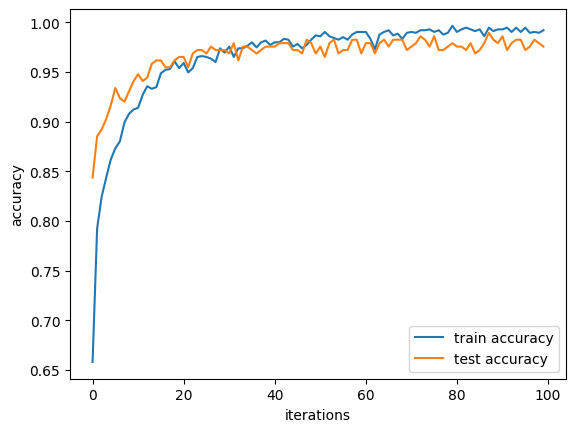

In [12]:
input_shape = (xg_train.shape[1], 1)  # Adjust based on your X_train shape
gender_classification_model = build_gender_classification_model(input_shape, xg_train, yg_train, xg_test, yg_test)

In [13]:
print(gender_classification_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 159, 128)          1408      
                                                                 
 conv1d_5 (Conv1D)           (None, 150, 256)          327936    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 75, 256)          0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 75, 256)           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 66, 256)           655616    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 33, 256)          0         
 1D)                                                  

# Emotion and Gender Prediction

In [24]:
def predict_emotion_gender(audio_file):
    try:
        # Load the audio file
        audio, sr = librosa.load(audio_file, sr=22050)

        # Extract features
        features = ['mfcc', 'chroma', 'mel']
        feature_vector = extract_features(audio_file, features, sr)
        # print("Extracted Features:", feature_vector)  # Debugging line

        # Normalize the features
        feature_vector = scale(feature_vector).reshape(1, -1)
        # print("Normalized Features:", feature_vector)  # Debugging line

        # Predict emotion
        emotion_pred = emotion_model.predict(feature_vector)
        predicted_emotion = np.argmax(emotion_pred, axis=1)[0]

        # Predict Gender 
        gender_pred = gender_classification_model.predict(feature_vector)
        predicted_gender = np.argmax(gender_pred, axis=1)[0]

        # Map the predicted values back to their respective categories
        emotion_labels = {0: 'neutral', 1: 'calm', 2: 'happy', 3: 'sad', 4: 'angry', 5: 'fearful', 6: 'disgust', 7: 'surprised'}
        gender_labels = {0: 'female', 1: 'male'}

        # Output the results
        print(f"Predicted Emotion: {emotion_labels[predicted_emotion]}")
        print(f"Predicted Gender: {gender_labels[predicted_gender]}")

    except Exception as e:
        print(f"Error processing the audio file: {e}")

# Test the model with an audio file
audio_path = r'audio_dataset\Actor_01\03-01-08-01-02-02-01.wav'
predict_emotion_gender(audio_path)


1/1 [==============================] - 0s 22ms/step
Predicted Emotion: surprised
Predicted Gender: male
